<h1>MPST: Movie Plot Synopses with Tags</h1>

# 1. Business Problem

## 1.1 Description

Abstract Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.

#### Problem Statement
- Identify which tag should be assigned to which movie.  
- we present the MPST corpus that contains plot synopses of 14,828 movies and their associations with a set of fine-grained tags, where each movie is tagged with one or more tags.

## 1.2 Sources

Dataset : https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

Please find the paper here: https://www.aclweb.org/anthology/L18-1274

This dataset was published in LREC 2018@Miyazaki, Japan.

Keywords Tag generation for movies, Movie plot analysis, Multi-label dataset, Narrative texts

More information is available here http://ritual.uh.edu/mpst-2018/

## 1.3 Real world/Business Objectives and Constraints

1. Predict as many tags as possible with high precision and recall.
2. No strict latency concerns.

# 2. Machine Learning Probelm

## 2.1 Data

<p> 
- Data will be in a csv file<br>
- Train.csv contains 6 columns : imdb_id, title, plot_synopsis, tags, split, synopsis_source <br>
- Size of Train.csv - 28MB <br>
- Number of rows in Train.csv = 14,828
</p>

## 2.2 Mapping the real-world problem to a Machine Learning Problem

### 2.2.1 Type of Machine Learning Problem

It is a multi-label classification problem 
Multi-label Classification: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document.

### 2.2.2 Performance metric

'Micro f1 score': 
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.

# 3. Exploratory Data Analysis

## 3.1 Data Loading and Cleaning

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import pickle
import re
import os
import string
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

In [2]:
raw_data = pd.read_csv('mpst_full_data.csv', delimiter=',')

In [3]:
raw_data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


#### Finding and removing duplicate entries

In [4]:
dup_removed = raw_data.drop_duplicates(['title','plot_synopsis','split'])

In [5]:
dup_removed.count()[0]

14486

In [6]:
null_columns=dup_removed.columns[dup_removed.isnull().any()]
print(dup_removed[dup_removed.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [7]:
tuple(dup_removed['split'].unique())

('train', 'test', 'val')

In [8]:
objects = tuple(dup_removed['split'].unique())
y_pos = np.arange(len(objects))
performance = [dup_removed[dup_removed['split'] == 'train'].count()[0],dup_removed[dup_removed['split'] == 'test'].count()[0],dup_removed[dup_removed['split'] == 'val'].count()[0]]

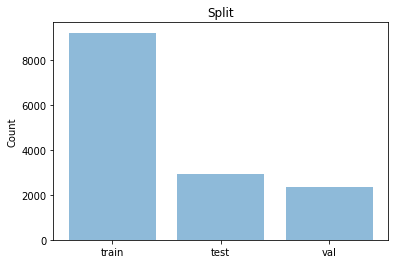

In [9]:
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Split')

plt.show()

## 3.2 Split into train, val and test

In [10]:
train = dup_removed[dup_removed['split'] == 'train']
train.count()[0]

9203

In [11]:
test = dup_removed[dup_removed['split'] == 'test']
test.count()[0]

2934

In [12]:
val = dup_removed[dup_removed['split'] == 'val']
val.count()[0]

2349

## 3.3 Analysis of Tags

In [13]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.replace(' ', '').split(','))
tag_vector = vectorizer.fit_transform(train['tags'])

In [14]:
print("Number of data points :", tag_vector.shape[0])
print("Number of unique tags :", tag_vector.shape[1])

Number of data points : 9203
Number of unique tags : 71


In [15]:
tags = vectorizer.get_feature_names()
print("Tags we have :", tags)

Tags we have : ['absurd', 'action', 'adultcomedy', 'allegory', 'alternatehistory', 'alternatereality', 'antiwar', 'atmospheric', 'autobiographical', 'avantgarde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christianfilm', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'goodversusevil', 'gothic', 'grindhousefilm', 'haunting', 'historical', 'historicalfiction', 'homemovie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magicalrealism', 'melodrama', 'murder', 'mystery', 'neonoir', 'nonfiction', 'paranormal', 'philosophical', 'plottwist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']


In [16]:
freqs = tag_vector.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [17]:
result

{'absurd': 166,
 'action': 397,
 'adultcomedy': 82,
 'allegory': 87,
 'alternatehistory': 63,
 'alternatereality': 126,
 'antiwar': 71,
 'atmospheric': 262,
 'autobiographical': 28,
 'avantgarde': 155,
 'blaxploitation': 56,
 'bleak': 139,
 'boring': 329,
 'brainwashing': 77,
 'christianfilm': 27,
 'claustrophobic': 52,
 'clever': 58,
 'comedy': 1178,
 'comic': 63,
 'cruelty': 276,
 'cult': 1650,
 'cute': 116,
 'dark': 252,
 'depressing': 124,
 'dramatic': 252,
 'entertaining': 445,
 'fantasy': 319,
 'feel-good': 48,
 'flashback': 1814,
 'goodversusevil': 535,
 'gothic': 279,
 'grindhousefilm': 44,
 'haunting': 94,
 'historical': 169,
 'historicalfiction': 93,
 'homemovie': 96,
 'horror': 301,
 'humor': 523,
 'insanity': 403,
 'inspiring': 67,
 'intrigue': 99,
 'magicalrealism': 34,
 'melodrama': 289,
 'murder': 3588,
 'mystery': 320,
 'neonoir': 451,
 'nonfiction': 22,
 'paranormal': 325,
 'philosophical': 152,
 'plottwist': 121,
 'pornographic': 101,
 'prank': 166,
 'psychedelic': 11

In [18]:
tag_quest_count = tag_vector.sum(axis=1).tolist()
tag_quest_count=[int(j) for i in tag_quest_count for j in i]

In [19]:
print( "Maximum number of tags per movie: %d"%max(tag_quest_count))
print( "Minimum number of tags per movie: %d"%min(tag_quest_count))
print( "Avg. number of tags per movie: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per movie: 25
Minimum number of tags per movie: 1
Avg. number of tags per movie: 2.977181


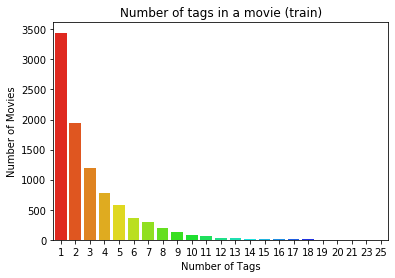

In [20]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in a movie (train)")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Movies")
plt.show()

### Most Frequent Tags

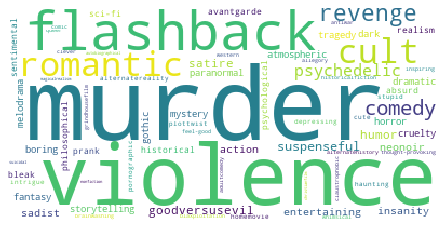

In [21]:
tup = dict(result.items())

wordcloud = WordCloud(background_color='white').generate_from_frequencies(tup)

fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag_wordcloud.png")
plt.show()

## 3.4 Cleaning and preprocessing of Plot, Title and tags

In [22]:
train_set = train.drop(['split','synopsis_source','imdb_id'], axis=1)
test_set = test.drop(['split','synopsis_source','imdb_id'],axis=1)
val_set = val.drop(['split','synopsis_source','imdb_id'],axis=1)

In [23]:
train_set['tags'] = train_set['tags'].apply(lambda x : x.replace(' ', '').replace(',',' '))
test_set['tags'] = test_set['tags'].apply(lambda x : x.replace(' ', '').replace(',',' '))
val_set['tags'] = val_set['tags'].apply(lambda x : x.replace(' ', '').replace(',',' '))

In [24]:
train_set.head()

,title,plot_synopsis,tags
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,cult horror gothic murder atmospheric
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...",inspiring romantic stupid feel-good
6,Baise-moi,Baise-moi tells the story of Nadine and Manu w...,gothic cruelty violence cult revenge sadist
7,Flightplan,Kyle Pratt (Jodie Foster) is a propulsion engi...,mystery suspenseful action murder flashback


In [25]:
from tqdm import tqdm
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
preprocessed_plot_train = []
# tqdm is for printing the status bar
for sentance in tqdm(train_set['plot_synopsis'].values):
    sentance = sentance.lower()
    sentance = re.sub(r'\d+', '', sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = sentance.strip()
    sentance = word_tokenize(sentance)
    sentance= ' '.join(str(stemmer.stem(j)) for j in sentance if j not in stop_words)
    preprocessed_plot_train.append(sentance.strip())

100%|██████████| 9203/9203 [01:48<00:00, 84.87it/s] 


In [26]:
preprocessed_plot_train[0]

'note synopsi orgin italian releas segment certain order bori karloff introduc three horror tale macabr supernatur known three face fear telephonerosi michel mercier attract high price parisian call girl return spacious basement apart even immedi get beset seri strang phone call caller soon identifi frank ex pimp recent escap prison rosi terrifi testimoni land man jail look solac rosi phone lesbian lover mari lynda alfonsi two women estrang time rosi certain one help mari agre come night second later frank call promis matter call protect reveng unknown rosi mari caller imperson frank marri arriv rosi apart soon best calm rosi nerv give panic struck woman tranquil put bed later night rosi sleep mari get bed pen note confess one make strang phone call learn frank escap prison know rosi would call help explain felt way come back life breakup busi write fail notic intrud apart time frank real creep behind mari strangl death one rosi nylon stock sound struggl awaken rosi gasp fright murder 

In [27]:
from tqdm import tqdm
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
preprocessed_plot_test = []
# tqdm is for printing the status bar
for sentance in tqdm(test_set['plot_synopsis'].values):
    sentance = sentance.lower()
    sentance = re.sub(r'\d+', '', sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = sentance.strip()
    sentance = word_tokenize(sentance)
    sentance= ' '.join(str(stemmer.stem(j)) for j in sentance if j not in stop_words)
    preprocessed_plot_test.append(sentance.strip())

100%|██████████| 2934/2934 [00:35<00:00, 81.73it/s] 


In [28]:
preprocessed_plot_test[0]

'matuschek gift store budapest workplac alfr kralik jame stewart newli hi ed klara novak margaret sullavan work constant irrit daili aggrav temper fact secret pen pal trade long soul search letter romant correspond sent back forth alfr klara trade barb work dream someday meet sensit care unknown pen pal christma fast approach store busi alfr store time alway treat well mr matuschek frank morgan late attitud chang alfr loss matuschek avoid explan final tell alfr would best left stun alfr accept last paycheck say goodby everyon includ klara civil long await meet secret pen pal plan night alfr lost job desir go find fight curios wander restaur agre meet peek window fellow employe cours klara wait chosen book wear red carnat agre use signal realiz wrong along irrit actual mask attract final enter goe tabl reveal true reason although awar hurt pen pal show alfr hurt rude final leav know wait night someon longer come meanwhil back store mr matuschek late night meet privat detect know wife af

In [29]:
from tqdm import tqdm
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
preprocessed_plot_val = []
# tqdm is for printing the status bar
for sentance in tqdm(val_set['plot_synopsis'].values):
    sentance = sentance.lower()
    sentance = re.sub(r'\d+', '', sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = sentance.strip()
    sentance = word_tokenize(sentance)
    sentance= ' '.join(str(stemmer.stem(j)) for j in sentance if j not in stop_words)
    preprocessed_plot_val.append(sentance.strip())

100%|██████████| 2349/2349 [00:29<00:00, 78.58it/s] 


In [30]:
preprocessed_plot_val[0]

'may cuban man name toni montana al pacino claim asylum florida usa search american dream depart cuba mariel boatlift question three tough talk in offici notic tattoo toni left arm black heart pitchfork identifi hitman detain camp call freedomtown cuban includ toni best friend former cuban armi buddi manolo manni ray ribiera steven bauer local expressway govern evalu visa petit day government dither camp rumor manni receiv offer cuban mafia quick relay toni kill emilio rebenga roberto contrera former aid fidel castro detain freedomtown receiv green card toni agre kill rebenga riot freedomtown murder rebenga request frank l pez wealthi polit astut man deal car trade cocain rebenga tortur l pez brother death still cuba mani year earlier get green card toni montana manni ray find work dishwash corner sandwich taco shop week later l pez henchman underboss omar su rez f murray abraham man contact manni rebenga hit job offer toni manni low risk job unload marijuana boat mexico arriv miami fo

In [31]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_train = vectorizer.fit_transform(train_set['tags'])
multilabel_test = vectorizer.transform(test_set['tags'])
multilable_val = vectorizer.transform(val_set['tags'])

In [39]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: x.split(),smooth_idf=True, norm="l2",sublinear_tf=False, ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(preprocessed_plot_train)
x_test_multilabel = vectorizer.transform(preprocessed_plot_test)
x_val_multilabel = vectorizer.transform(preprocessed_plot_val)

In [40]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",multilabel_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",multilabel_test.shape)
print("Dimensions of val data X:",x_val_multilabel.shape,"Y:",multilable_val.shape)

Dimensions of train data X: (9203, 11283746) Y : (9203, 71)
Dimensions of test data X: (2934, 11283746) Y: (2934, 71)
Dimensions of val data X: (2349, 11283746) Y: (2349, 71)


## 3.5 Applying Logistic Regression with OneVsRest Classifier

In [41]:
alpha = [10**i for i in range(-8,-2)]

### Hyper parameter tuning using validation set

In [43]:
for i in alpha:
    start = datetime.now()
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1'))
    classifier.fit(x_train_multilabel, multilabel_train)
    predictions = classifier.predict(x_val_multilabel)

    print("Alpha : ",i)
    print("Accuracy :",metrics.accuracy_score(multilable_val, predictions))
    print("Hamming loss ",metrics.hamming_loss(multilable_val,predictions))


    precision = precision_score(multilable_val, predictions, average='micro')
    recall = recall_score(multilable_val, predictions, average='micro')
    f1 = f1_score(multilable_val, predictions, average='micro')

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Time taken to run this iteration :", datetime.now() - start)

Alpha :  1e-08
Accuracy : 0.05874840357598978
Hamming loss  0.04860923737400992
Micro-average quality numbers
Precision: 0.3994, Recall: 0.2806, F1-measure: 0.3296
Time taken to run this iteration : 0:02:49.619334
Alpha :  1e-07
Accuracy : 0.06002554278416347
Hamming loss  0.04665455483004455
Micro-average quality numbers
Precision: 0.4263, Recall: 0.2759, F1-measure: 0.3350
Time taken to run this iteration : 0:02:25.114052
Alpha :  1e-06
Accuracy : 0.04938271604938271
Hamming loss  0.05360986694967592
Micro-average quality numbers
Precision: 0.3662, Recall: 0.3542, F1-measure: 0.3601
Time taken to run this iteration : 0:02:22.810547
Alpha :  1e-05
Accuracy : 0.05917411664538101
Hamming loss  0.048057609171418464
Micro-average quality numbers
Precision: 0.4170, Recall: 0.3227, F1-measure: 0.3638
Time taken to run this iteration : 0:02:17.202574
Alpha :  0.0001
Accuracy : 0.05065985525755641
Hamming loss  0.040214895160661714
Micro-average quality numbers
Precision: 0.6110, Recall: 0.15

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=10**-5, penalty='l1'))
classifier.fit(x_train_multilabel, multilabel_train)
predictions = classifier.predict(x_test_multilabel)

print('TEST SCORES')

print("Accuracy :",metrics.accuracy_score(multilabel_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_test,predictions))


precision = precision_score(multilabel_test, predictions, average='micro')
recall = recall_score(multilabel_test, predictions, average='micro')
f1 = f1_score(multilabel_test, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("Time taken to run this iteration :", datetime.now() - start)

TEST SCORES
Accuracy : 0.07021131561008861
Hamming loss  0.048143667732365565
Micro-average quality numbers
Precision: 0.4208, Recall: 0.3241, F1-measure: 0.3662
Time taken to run this iteration : 0:02:57.639340


# Conclusion

In [45]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter (Alpha)", "Precision", "Recall", "F1 Score"]
x.add_row(["TFIDF ngram(1,4)", "LogisticRegression", 10**-5, 0.4208, 0.3341, 0.3662])

print(x)

+------------------+--------------------+-------------------------+-----------+--------+----------+
|    Vectorizer    |       Model        | Hyper parameter (Alpha) | Precision | Recall | F1 Score |
+------------------+--------------------+-------------------------+-----------+--------+----------+
| TFIDF ngram(1,4) | LogisticRegression |          1e-05          |   0.4208  | 0.3341 |  0.3662  |
+------------------+--------------------+-------------------------+-----------+--------+----------+


#### Steps followed in Case Study

- ____Step 1____ : Analyze data and determine features that can be built using the dataset.
- ____Step 2____ : In this case study TFIDF is used for feature extraction.
- ____Step 3____ : Split data into Test,val and Train data. 
- ____Step 4____ : Fit train data on each feature and extract corresponding values on test and val data.
- ____Step 5____ : Apply Logistic Regression.
- ____Step 6____ : Find the corresponding Micro F1 score in each case.
- ____Step 7____ : The best model is determined with one having the most F1 score.

- ____Observations____ : In the following case study, Logistic Regression shows better scores with precision of 0.42, recall of 0.33 and F1 score of 0.36.